In [47]:
CUDA_VISIBLE_DEVICES=""

import warnings
warnings.filterwarnings('ignore')

import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

import random
import os


import tensorflow as tf
from tensorflow import keras

import glob

In [48]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.utils.set_random_seed(42)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [49]:
img_height = 224
img_width = 224
batch_size = 32
data_dir = "scaled_chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory=train_dir,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  directory=train_dir,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(train_ds.class_names)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
['NORMAL', 'PNEUMONIA']


In [51]:
#Setting callbakcs

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [52]:
def get_model():
    
    #Input shape = [width, height, color channels]
    inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = keras.layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.2)(x)

    # Block Two
    x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Block Three
    x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [53]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [54]:
history = model.fit(train_ds,
          batch_size = batch_size, epochs = 10,
          validation_data=val_ds,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=len(train_ds),
          validation_steps=len(val_ds))

Epoch 1/10
131/131 [==============================] - 58s 435ms/step - loss: 0.3601 - binary_accuracy: 0.8512 - val_loss: 0.3385 - val_binary_accuracy: 0.8757 - lr: 3.0000e-05
Epoch 2/10
131/131 [==============================] - 50s 383ms/step - loss: 0.1952 - binary_accuracy: 0.9221 - val_loss: 0.1279 - val_binary_accuracy: 0.9570 - lr: 3.0000e-05
Epoch 3/10
131/131 [==============================] - 48s 366ms/step - loss: 0.1570 - binary_accuracy: 0.9398 - val_loss: 0.1111 - val_binary_accuracy: 0.9589 - lr: 3.0000e-05
Epoch 4/10
131/131 [==============================] - 49s 374ms/step - loss: 0.1385 - binary_accuracy: 0.9498 - val_loss: 0.0929 - val_binary_accuracy: 0.9637 - lr: 3.0000e-05
Epoch 5/10
131/131 [==============================] - 49s 376ms/step - loss: 0.1266 - binary_accuracy: 0.9558 - val_loss: 0.0935 - val_binary_accuracy: 0.9589 - lr: 3.0000e-05
Epoch 6/10
131/131 [==============================] - 51s 390ms/step - loss: 0.1087 - binary_accuracy: 0.9558 - val_loss

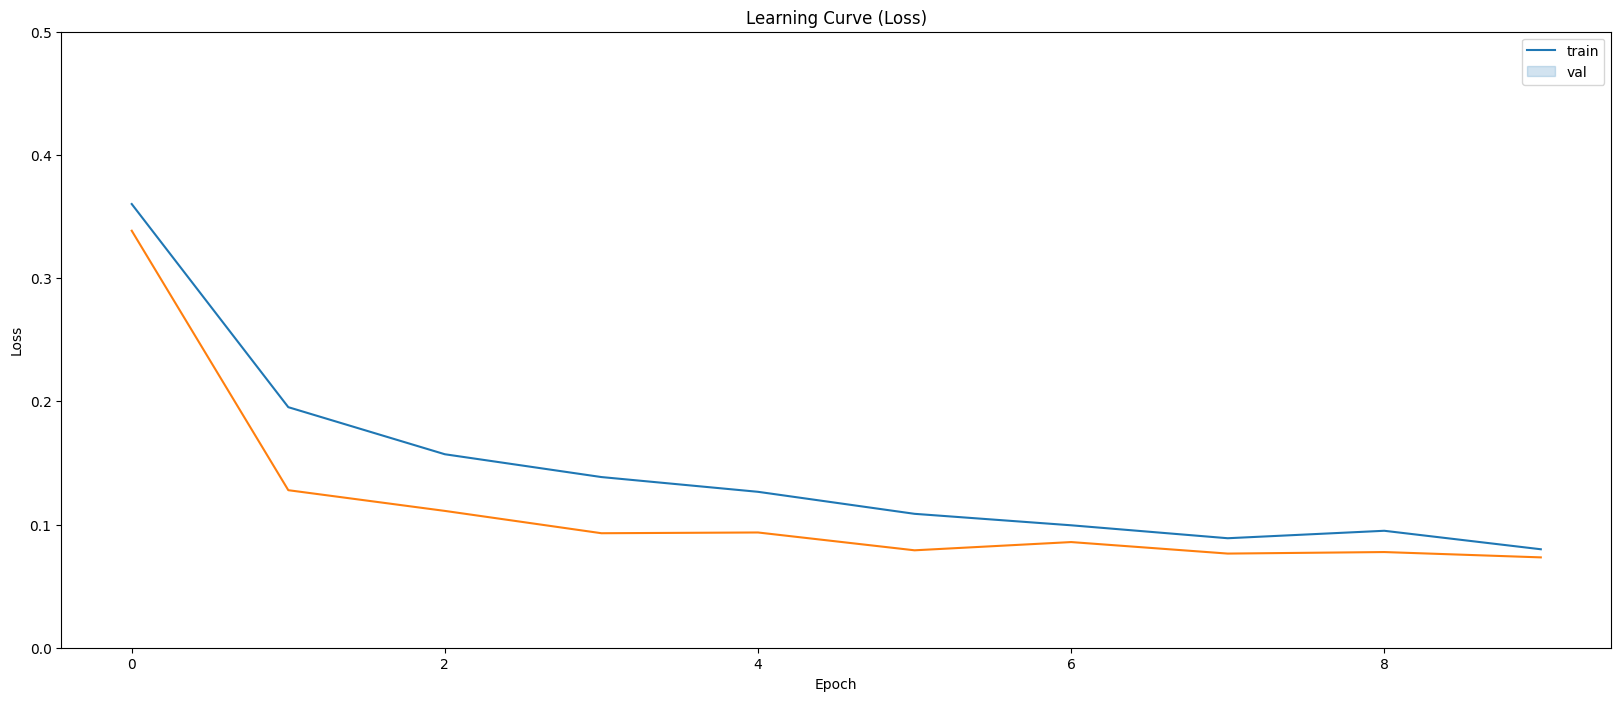

In [58]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

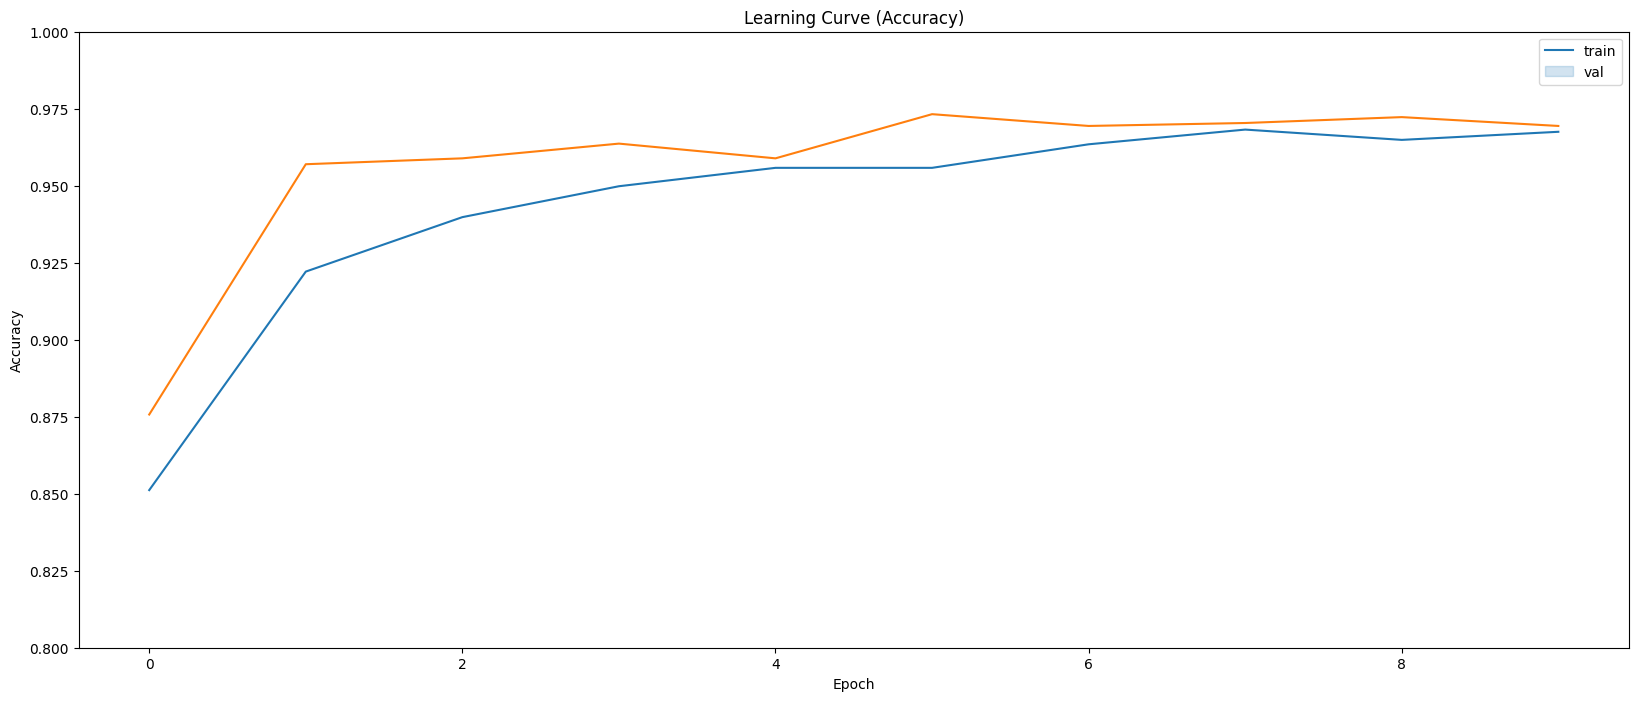

In [59]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [60]:
score = model.evaluate(val_ds, steps = len(val_ds), verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.0733289122581482
Val accuracy: 0.9694072604179382
